# Feature Selection
This notebook will include feature selection part for the dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
import warnings
import json
import pickle
warnings.filterwarnings('ignore')

In [2]:
modified = "../../data/modified/"

In [3]:
OneHotFile = modified + "OneHotDerived2.pkl"
OneHotData = pickle.load(open(OneHotFile, "rb"))

In [4]:
df_train_oneHot = OneHotData["train"]
df_test_oneHot = OneHotData["test"]

In [5]:
corr = df_train_oneHot.corr()["SalePrice"]
corr = corr[np.argsort(np.abs(corr), axis=0)[::-1]]
corr.drop("SalePrice", inplace=True)

In [6]:
def plot_corr(corr):
    corr_display = pd.DataFrame()
    corr_display["feature"] = pd.Series(corr.index)
    corr_display["Correlations"] = pd.Series(corr.values)
    plt.figure(figsize = (6, 0.25*len(corr.index)))
    sns.barplot(data=corr_display, y="feature", x="Correlations", orient="h")

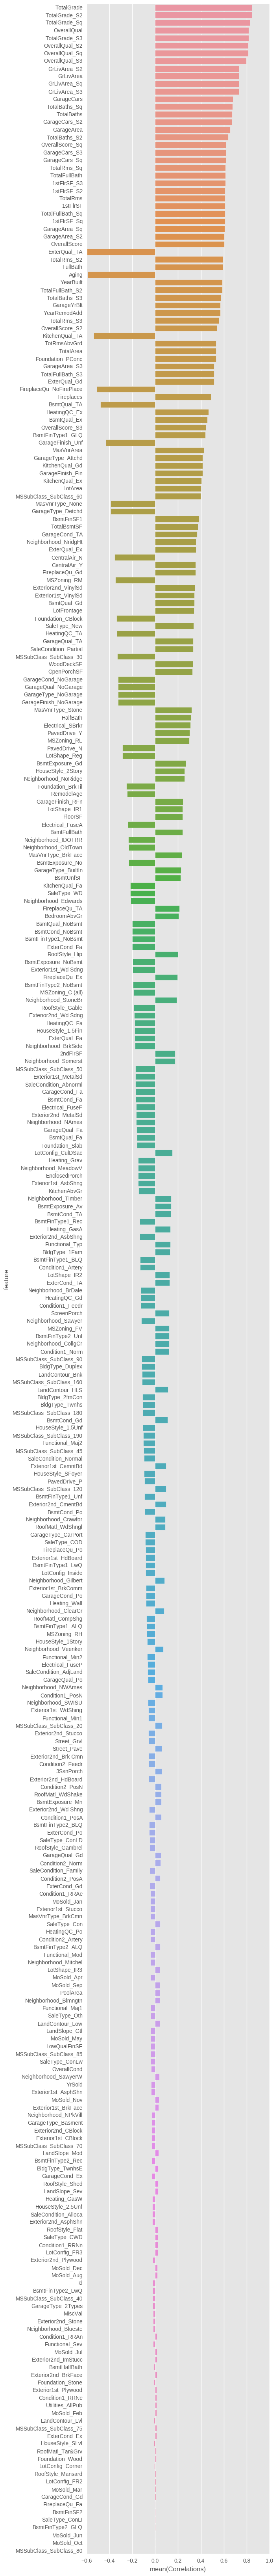

In [7]:
plot_corr(corr)

In [8]:
df_train_oneHot.drop("Id", axis=1, inplace=True)
target = df_train_oneHot["SalePrice"]
df_train_oneHot.drop("SalePrice", axis=1, inplace=True)

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

scorer = make_scorer(mean_squared_error, False)
def rmse_cv(model, X, y):
    return (cross_val_score(model, X, y, scoring=scorer)).mean()

In [10]:
Id = df_test_oneHot["Id"]
df_test_oneHot.drop("Id", axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train_oneHot)
df_train_oneHot.loc[:,:] = scaler.transform(df_train_oneHot)
df_test_oneHot.loc[:,:] = scaler.transform(df_test_oneHot)

## Lasso feature selection
[Lasso](http://scikit-learn.org/stable/modules/linear_model.html#lasso) is a linear model that yields sparse models, therefore it can be used to do the feature selection.

In [ ]:
from sklearn.linear_model import Lasso
alphas =[3e-4, 5e-4, 1e-3,2e-3,4e-3,5e-3,7e-3, 1e-2]
cv_lasso = [rmse_cv(Lasso(alpha=alpha, max_iter=50000), df_train_oneHot, target) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

In [ ]:
model = Lasso(alpha = 4e-3, max_iter = 50000).fit(df_train_oneHot, target)

In [ ]:
selected = df_train_oneHot.columns.values[abs(model.coef_) > 0]

In [ ]:
selected = list(selected)
print(selected)

In [ ]:
p_pred = np.expm1(model.predict(df_train_oneHot))
plt.scatter(p_pred, np.expm1(target))
plt.plot([min(p_pred), max(p_pred)], [min(p_pred), max(p_pred)], c= "red")

In [ ]:
p = np.expm1(model.predict(df_test_oneHot))
solution = pd.DataFrame({"id":Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("../../data/submission/OneHotDerived2-Lasso.csv", index = False)

In [ ]:
train_X = df_train_oneHot[selected]
test_X = df_test_oneHot[selected]
OneHot_Lasso = modified + "OneHotDerived2_Lasso.pkl"
OneHot = {"train_X": train_X, "test_X": test_X, "y": target, "id": Id}
with open(OneHot_Lasso, 'wb') as f:
    pickle.dump(OneHot, f , pickle.HIGHEST_PROTOCOL)

## Randomized Lasso
Randomized Lasso is a stability selection that can be used for feature selection.

In [ ]:
from sklearn.linear_model import RandomizedLasso
rlasso = RandomizedLasso(alpha=alphas, random_state=25)
rlasso.fit(df_train_oneHot, target)

In [ ]:
feature_display = pd.DataFrame()
feature_display["Features"] = pd.Series(list(df_train_oneHot.columns.values))
feature_display["Score"] = pd.Series(rlasso.scores_)

In [ ]:
feature_display = feature_display.sort_values(by= "Score", ascending=False)
plt.figure(figsize = (6, 0.25*len(list(df_train_oneHot.columns.values))))
sns.barplot(data=feature_display, y="Features", x="Score", orient="h")

In [ ]:
scores = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [ ]:
for score in scores:
    selected = feature_display[feature_display["Score"] > score]["Features"]
    train_X = df_train_oneHot[selected]
    test_X = df_test_oneHot[selected]
    OneHot_Lasso = modified + "OneHotDerived2_RLasso" + str(score*10)+".pkl"
    OneHot = {"train_X": train_X, "test_X": test_X, "y": target, "id": Id}
    with open(OneHot_Lasso, 'wb') as f:
        pickle.dump(OneHot, f , pickle.HIGHEST_PROTOCOL)

Similar to the Baysian mean method data.

In [ ]:
BayesianFile = modified + "BayesianDerived2.pkl"
BayesianData = pickle.load(open(BayesianFile, "rb"))

In [ ]:
df_train_Bayesian = BayesianData["train"]
df_test_Bayesian = BayesianData["test"]

In [ ]:
df_train_Bayesian.drop("Id", axis=1, inplace=True)
target = df_train_Bayesian["SalePrice"]
df_train_Bayesian.drop("SalePrice", axis=1, inplace=True)

In [ ]:
Id = df_test_Bayesian["Id"]
df_test_Bayesian.drop("Id", axis=1, inplace=True)

In [ ]:
scaler = StandardScaler().fit(df_train_Bayesian)
df_train_Bayesian.loc[:,:] = scaler.transform(df_train_Bayesian)
df_test_Bayesian.loc[:,:] = scaler.transform(df_test_Bayesian)

In [ ]:
alphas =[8e-4, 1e-3,1.5e-3,2e-3,2.5e-3, 3e-3,4e-3]
cv_lasso = [rmse_cv(Lasso(alpha=alpha, max_iter=50000), df_train_Bayesian, target) for alpha in alphas]
pd.Series(cv_lasso, index = alphas).plot()

In [ ]:
model = Lasso(alpha = 1.5e-3, max_iter =  50000).fit(df_train_Bayesian, target)

In [ ]:
selected = df_train_Bayesian.columns.values[abs(model.coef_) > 0]

In [ ]:
selected = list(selected)
print(selected)

In [ ]:
len(selected)

In [ ]:
p_pred = np.expm1(model.predict(df_train_Bayesian))
plt.scatter(p_pred, np.expm1(target))
plt.plot([min(p_pred), max(p_pred)], [min(p_pred), max(p_pred)], c= "red")

In [ ]:
p = np.expm1(model.predict(df_test_Bayesian))
solution = pd.DataFrame({"id":Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("../../data/submission/BayesianDerived2-Lasso.csv", index = False)

In [ ]:
train_X = df_train_Bayesian[selected]
test_X = df_test_Bayesian[selected]
Bayesian_Lasso = modified + "BayesianDerived2_Lasso.pkl"
Bayesian = {"train_X": train_X, "test_X": test_X, "y": target, "id": Id}
with open(Bayesian_Lasso, 'wb') as f:
    pickle.dump(Bayesian, f , pickle.HIGHEST_PROTOCOL)

In [ ]:
rlasso = RandomizedLasso(alpha=alphas, random_state=25)
rlasso.fit(df_train_Bayesian, target)

In [ ]:
feature_display = pd.DataFrame()
feature_display["Features"] = pd.Series(list(df_train_Bayesian.columns.values))
feature_display["Score"] = pd.Series(rlasso.scores_)

In [ ]:
feature_display = feature_display.sort_values(by= "Score", ascending=False)
plt.figure(figsize = (6, 0.25*len(list(df_train_Bayesian.columns.values))))
sns.barplot(data=feature_display, y="Features", x="Score", orient="h")

In [ ]:
for score in scores:
    selected = feature_display[feature_display["Score"] > score]["Features"]
    train_X = df_train_Bayesian[selected]
    test_X = df_test_Bayesian[selected]
    Bayesian_Lasso = modified + "BayesianDerived2_RLasso" + str(score * 10) + ".pkl"
    Bayesian = {"train_X": train_X, "test_X": test_X, "y": target, "id": Id}
    with open(Bayesian_Lasso, 'wb') as f:
        pickle.dump(Bayesian, f , pickle.HIGHEST_PROTOCOL)